In [1]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '../Fuentes'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = '../Datos/' # carpeta donde se encuentran los datasets

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

In [2]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense 
from tensorflow.keras.utils import to_categorical

import numpy as np
from sklearn import preprocessing, metrics, model_selection 
import pandas as pd

In [3]:
df = pd.read_csv(DATOS_DIR + 'Iris.csv')

# Tomamos todas las columnas menos la última
X = np.array(df.iloc[:, 0:-1])
T = np.array(df.iloc[:,-1])

# Binarizador para convertir el nombre de la clase en one hot encoding
binarizer = preprocessing.LabelBinarizer()

# Binariza cada clase como una combinación de un 1 y 0s
T = binarizer.fit_transform(T)

print('Clases :', binarizer.classes_)


Clases : ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


In [4]:
#--- CONJUNTOS DE ENTRENAMIENTO Y TESTEO ---
X_train, X_test, T_train, T_test = model_selection.train_test_split( \
        X, T, test_size=0.30) #, random_state=42)

#Y_trainB = to_categorical(Y_train)

In [5]:
normalizarEntrada = 1  # 1 si normaliza; 0 si no

if normalizarEntrada:
    # Escala los valores entre 0 y 1
    min_max_scaler = preprocessing.MinMaxScaler()
    X_train = min_max_scaler.fit_transform(X_train)
    X_test = min_max_scaler.transform(X_test)

### Definición del modelo

In [6]:

# Crear un modelo de capas secuenciales
model=Sequential()

# Agregar las capas al modelo
model.add(Dense(2, input_shape=[4], activation='tanh'))
model.add(Dense(3, activation='softmax'))

# Imprimir un resumen del modelo
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 10        
                                                                 
 dense_1 (Dense)             (None, 3)                 9         
                                                                 
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________


In [7]:
from tensorflow.keras.optimizers import SGD

model.compile(optimizer=SGD(learning_rate=0.05), loss='categorical_crossentropy', metrics=['accuracy'])



In [8]:
from tensorflow.keras.callbacks import LambdaCallback

# Define el callback
def on_epoch_end(epoch, logs):
    if (epoch + 1) % 100 == 0:  # Cambia 10 por el número de épocas deseado
        print(f"Epoch {epoch + 1}: loss = {logs['loss']}, accuracy = {logs['accuracy']}")

# Crea el LambdaCallback
epoch_end_callback = LambdaCallback(on_epoch_end=on_epoch_end)

# Entrena el modelo con el callback
history = model.fit(X_train,T_train, epochs=1000, batch_size=20, validation_split=0.25, callbacks=[epoch_end_callback], verbose=0)


Epoch 100: loss = 0.4505792260169983, accuracy = 0.9615384340286255
Epoch 200: loss = 0.30119481682777405, accuracy = 0.9743589758872986
Epoch 300: loss = 0.19655905663967133, accuracy = 0.9743589758872986
Epoch 400: loss = 0.134582981467247, accuracy = 0.9743589758872986
Epoch 500: loss = 0.10182115435600281, accuracy = 0.9743589758872986
Epoch 600: loss = 0.07998720556497574, accuracy = 0.9743589758872986
Epoch 700: loss = 0.06758098304271698, accuracy = 0.9743589758872986
Epoch 800: loss = 0.059510793536901474, accuracy = 0.9871794581413269
Epoch 900: loss = 0.05339682847261429, accuracy = 0.9871794581413269
Epoch 1000: loss = 0.04978373274207115, accuracy = 0.9743589758872986


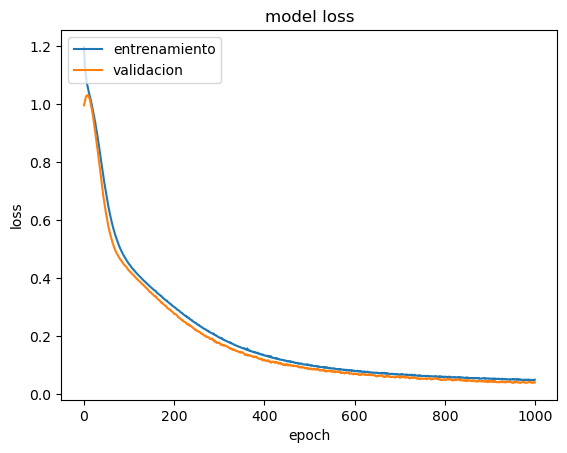

In [9]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validacion'], loc='upper left')
plt.show()

In [10]:
# Evaluación del modelo
score = model.evaluate(X_train, T_train) 

print('Error :', score[0]) 
print('Accuracy:', score[1])


4/4 [==============================] - 0s 6ms/step - loss: 0.0457 - accuracy: 0.9905
Error : 0.045671459287405014
Accuracy: 0.9904761910438538


In [11]:
# predecir la salida del modelo
Y = model.predict(X_train)

# "invierte" la transformacion binaria para obtener los nombres de las clases
T_str = binarizer.inverse_transform(T_train)
Y_str = binarizer.inverse_transform(Y)

print("%% aciertos : %.3f" % metrics.accuracy_score(T_str, Y_str))
print(Y[:5,:])
print(Y_str[:5])

4/4 [==============================] - 0s 1ms/step
% aciertos : 0.990
[[9.9151307e-01 8.4865000e-03 4.6747130e-07]
 [1.5350774e-06 4.7463416e-03 9.9525219e-01]
 [4.4577564e-03 9.6260554e-01 3.2936808e-02]
 [9.9158353e-01 8.4160296e-03 4.6676186e-07]
 [9.8862344e-01 1.1375904e-02 6.6310452e-07]]
['Iris-setosa' 'Iris-virginica' 'Iris-versicolor' 'Iris-setosa'
 'Iris-setosa']


In [12]:
report = metrics.classification_report(T_str, Y_str, target_names=binarizer.classes_)
print("Training metrics:\n%s" % report) 

MM = metrics.confusion_matrix(T_str, Y_str)
print("Confusion matrix:\n%s" % MM)

Training metrics:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        35
Iris-versicolor       0.97      1.00      0.99        36
 Iris-virginica       1.00      0.97      0.99        34

       accuracy                           0.99       105
      macro avg       0.99      0.99      0.99       105
   weighted avg       0.99      0.99      0.99       105

Confusion matrix:
[[35  0  0]
 [ 0 36  0]
 [ 0  1 33]]


In [13]:
# predecir la salida del modelo
Y_test = model.predict(X_test)

# "invierte" la transformacion binaria para obtener los nombres de las clases
T_test_str = binarizer.inverse_transform(T_test)
Y_test_str = binarizer.inverse_transform(Y_test)

print("%% aciertos X_train : %.3f" % metrics.accuracy_score(T_test_str, Y_test_str))

2/2 [==============================] - 0s 0s/step
% aciertos X_train : 0.956


In [14]:
report = metrics.classification_report(T_test_str, Y_test_str) #, target_names=etiquetas)

print("Métricas de la clasificación:\n%s" % report) 

Métricas de la clasificación:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       1.00      0.86      0.92        14
 Iris-virginica       0.89      1.00      0.94        16

       accuracy                           0.96        45
      macro avg       0.96      0.95      0.95        45
   weighted avg       0.96      0.96      0.96        45



In [15]:
MM = metrics.confusion_matrix(T_test_str, Y_test_str)

print("Confusion matrix:\n%s" % MM)
# Convertimos la matriz de confusión en un DataFrame con etiquetas
etiquetas = binarizer.classes_
df_cm = pd.DataFrame(MM, index=etiquetas, columns=etiquetas)

# Mostramos el DataFrame resultante
print("\n\n",df_cm)

Confusion matrix:
[[15  0  0]
 [ 0 12  2]
 [ 0  0 16]]


                  Iris-setosa  Iris-versicolor  Iris-virginica
Iris-setosa               15                0               0
Iris-versicolor            0               12               2
Iris-virginica             0                0              16


In [16]:
capaOculta = model.layers[0]
W1, b1 = capaOculta.get_weights()

capaSalida = model.layers[1]
W2,b2 = capaSalida.get_weights()

print("W1")
print(W1)

print("b1")
print(b1)

print("W2")
print(W2)

print("b2")
print(b2)

W1
[[-0.55179965  0.826698  ]
 [ 1.8249011   1.0230846 ]
 [-1.7478445  -2.5640795 ]
 [-2.0934694  -3.4120378 ]]
b1
[0.6417748 2.9942079]
W2
[[ 3.932023  -1.3642011 -2.1480205]
 [ 3.4700282  1.8753171 -5.5098133]]
b2
[-0.3854971  1.0690534 -0.6835568]


In [17]:
#model.save("IRIS_Sigmoid.h5")